In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import tensorflow.keras.backend as K

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU détecté.")
else:
    print("Aucun GPU détecté, l'entraînement se fera sur le CPU.")


Aucun GPU détecté, l'entraînement se fera sur le CPU.


In [6]:
img_size = 150
batch_size = 32
epochs = 20
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'
padding_size = 20
num_folds = 5

In [10]:
# Fonction pour charger les données
def load_data(data_dir1, data_dir2, limit=100):
    print("Loading data...")
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for i, img in enumerate(os.listdir(path)):
            if i >= limit:
                break
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Failed to read {img}. Skipping.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print("Finished loading data.")
    return np.array(data, dtype=object)

train_data = load_data(data_dir1, data_dir2, limit=100)

Loading data...
Finished loading data.


In [14]:
def apply_corners_mask(image, mask_size=30):
    if len(image.shape) == 3:  
        mask = np.ones_like(image)
    else:  # Grayscale image
        mask = np.ones((image.shape[0], image.shape[1], 1))
    
    h, w = image.shape[:2]
    mask[:mask_size, :, :] = 0
    mask[-mask_size:, :, :] = 0
    mask[:, :mask_size, :] = 0
    mask[:, -mask_size:, :] = 0
    
    return image * mask

def preprocess_image(image):
    if len(image.shape) == 2:  # Grayscale image
        image = np.expand_dims(image, axis=-1)
    image = apply_corners_mask(image)  # Application du masque
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0  # Normalisation après redimensionnement
    return image

def preprocess_data(data):
    print("Preprocessing data...")
    processed_data = []
    for idx, (img, label) in enumerate(data):
        print(f"Processing image {idx+1}/{len(data)}")
        img = preprocess_image(img)
        processed_data.append([img, label])
    return np.array(processed_data, dtype=object)


img_size = 150

train_data = preprocess_data(train_data)

Preprocessing data...
Processing image 1/200
Processing image 2/200
Processing image 3/200
Processing image 4/200
Processing image 5/200
Processing image 6/200
Processing image 7/200
Processing image 8/200
Processing image 9/200
Processing image 10/200
Processing image 11/200
Processing image 12/200
Processing image 13/200
Processing image 14/200
Processing image 15/200
Processing image 16/200
Processing image 17/200
Processing image 18/200
Processing image 19/200
Processing image 20/200
Processing image 21/200
Processing image 22/200
Processing image 23/200
Processing image 24/200
Processing image 25/200
Processing image 26/200
Processing image 27/200
Processing image 28/200
Processing image 29/200
Processing image 30/200
Processing image 31/200
Processing image 32/200
Processing image 33/200
Processing image 34/200
Processing image 35/200
Processing image 36/200
Processing image 37/200
Processing image 38/200
Processing image 39/200
Processing image 40/200
Processing image 41/200
Pro

In [38]:
# Séparer les caractéristiques et les labels
def separate_features_labels(data):
    print("Separating features and labels...")
    features = []
    labels = []
    for img, label in data:
        features.append(img)
        labels.append(label)
    print("Separated")
    return np.array(features), np.array(labels)

x_data, y_data = separate_features_labels(train_data)
print("Reshaping...")
x_data = x_data.reshape(-1, img_size, img_size, 1)
print("Concatenating...")
x_data = np.concatenate([x_data, x_data, x_data], axis=-1)  # Convertir en 3 canaux

Separating features and labels...
Separated
Reshaping...
Concatenating...


In [46]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Validation croisée K-Fold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_model = None
best_accuracy = 0
best_model_path = None
history = None  # Initialiser la variable `history` pour être utilisée plus tard

In [48]:
for fold, (train_index, val_index) in enumerate(kf.split(x_data)):
    print(f"\nFold {fold + 1}/{num_folds}")
    
    x_train, x_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    # Initialiser ImageDataGenerator
    print("Initializing ImageDataGenerator...")
    datagen = ImageDataGenerator(
        zoom_range=0.1,
        shear_range=0.1
    )
    print("ImageDataGenerator initialized")
    datagen.fit(x_train)

    # Construire le modèle
    model = build_model(input_shape=(img_size, img_size, 3))

    # Définir les callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f"best_model_fold_{fold + 1}.keras", 
                                        save_best_only=True, 
                                        monitor='val_accuracy')

    # Entraîner le modèle
    print("Starting training...")
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[reduce_lr, early_stop, model_checkpoint])
    print("Training complete.")
    
    # Évaluer le modèle
    scores = model.evaluate(x_val, y_val, verbose=0)
    val_accuracy = scores[1] * 100
    print(f"Fold {fold + 1} Validation accuracy: {val_accuracy:.2f}%")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_model_path = f"best_model_fold_{fold + 1}.keras"

# Charger le meilleur modèle
print(f"Loading the best model from {best_model_path}")
best_model = tf.keras.models.load_model(best_model_path)


Fold 1/5
Initializing ImageDataGenerator...
ImageDataGenerator initialized
Starting training...
Epoch 1/20


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 839ms/step - accuracy: 0.5078 - loss: 0.7578 - val_accuracy: 0.5250 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 566ms/step - accuracy: 0.4788 - loss: 0.6914 - val_accuracy: 0.4750 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 688ms/step - accuracy: 0.4840 - loss: 0.6914 - val_accuracy: 0.4750 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 709ms/step - accuracy: 0.5594 - loss: 0.6865 - val_accuracy: 0.6000 - val_loss: 0.6714 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.5824 - loss: 0.6788 - val_accuracy: 0.5750 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - accuracy: 0.6085 - loss: 0.6470 - val_accuracy: 0.6750 - val_loss: 0.5939 - learning_rate: 0.0010
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 537ms/step - accuracy: 0.7410 - loss: 0.5824 - val_accuracy: 0.8250 - v

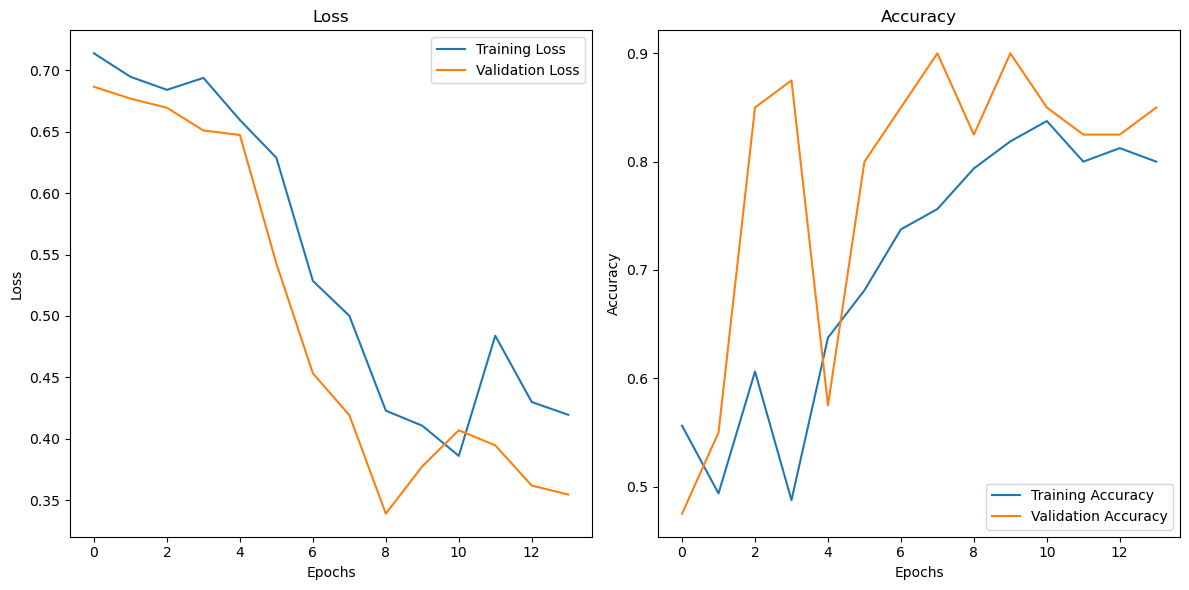

In [50]:
# Visualiser les courbes d'apprentissage
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Afficher les courbes d'apprentissage du meilleur modèle
if history:
    plot_learning_curves(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


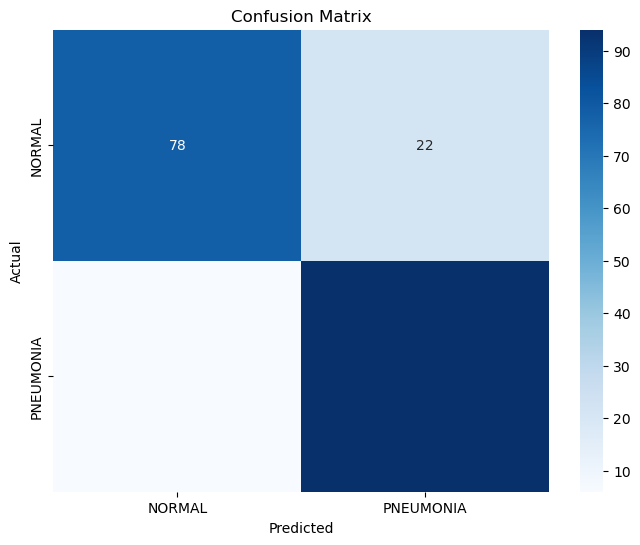

Another way of representation of the Confusion Matrix:
 [[78 22]
 [ 6 94]]


In [52]:
# Afficher la matrice de confusion
def display_confusion_matrix(model, x_data, y_data):
    y_pred = (model.predict(x_data) > 0.5).astype("int32")
    cm = confusion_matrix(y_data, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    print("Another way of representation of the Confusion Matrix:\n", cm)

display_confusion_matrix(best_model, x_data, y_data)

In [54]:
# Afficher le rapport de classification
def display_classification_report(model, x_data, y_data):
    y_pred = (model.predict(x_data) > 0.5).astype("int32")
    cr = classification_report(y_data, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
    print("Classification Report:\n", cr)

display_classification_report(best_model, x_data, y_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step 
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.93      0.78      0.85       100
   PNEUMONIA       0.81      0.94      0.87       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


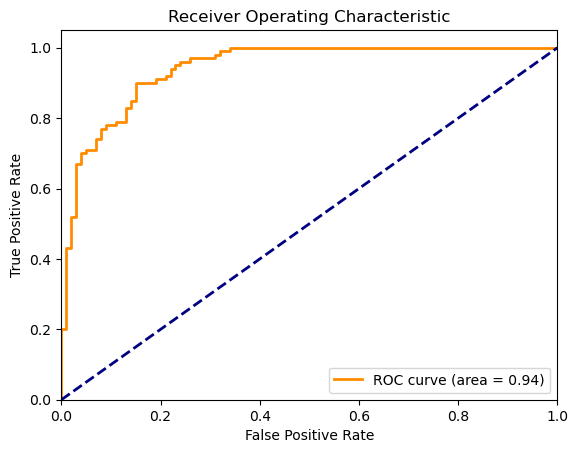

In [82]:
# Afficher la courbe ROC
def plot_roc_curve(model, x_data, y_data):
    y_pred = model.predict(x_data)
    fpr, tpr, _ = roc_curve(y_data, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(best_model, x_data, y_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


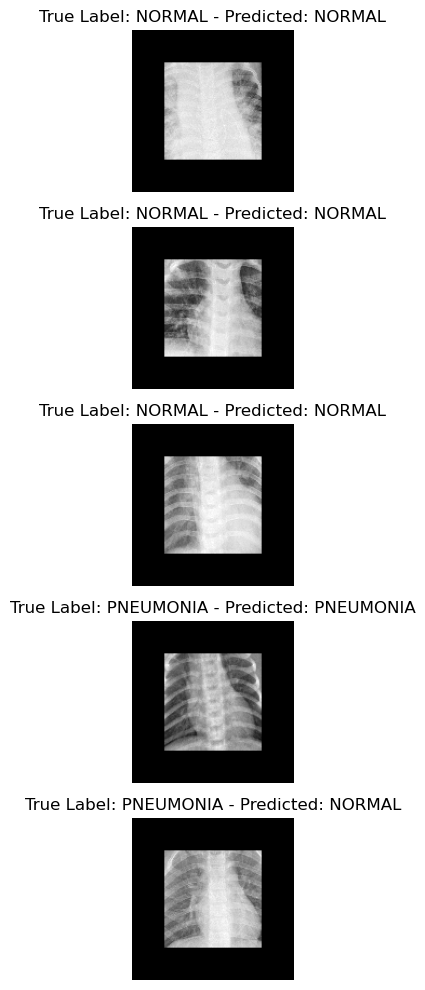

In [84]:
def display_predictions_simple(model, x_data, y_data, num_samples=5):
    idxs = np.random.choice(len(x_data), num_samples, replace=False)
    samples = x_data[idxs]
    true_labels = y_data[idxs]
    predictions = (model.predict(samples) > 0.5).astype("int32").flatten()

    plt.figure(figsize=(10, 10))
    for i, (img, true_label, pred) in enumerate(zip(samples, true_labels, predictions)):
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img[..., 0], cmap='gray')
        plt.title(f"True Label: {'PNEUMONIA' if true_label == 1 else 'NORMAL'} - Predicted: {'PNEUMONIA' if pred == 1 else 'NORMAL'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions_simple(best_model, x_data, y_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


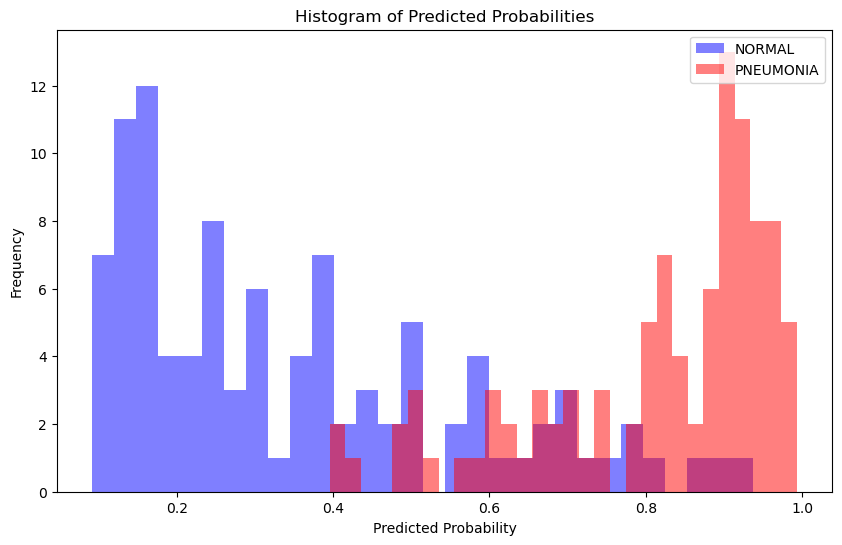

In [88]:
def plot_prediction_histogram(model, x_data, y_data):
    y_pred_proba = model.predict(x_data)
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred_proba[y_data == 0], bins=30, alpha=0.5, label='NORMAL', color='blue')
    plt.hist(y_pred_proba[y_data == 1], bins=30, alpha=0.5, label='PNEUMONIA', color='red')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Probabilities')
    plt.legend(loc='upper right')
    plt.show()

plot_prediction_histogram(best_model, x_data, y_data)

In [90]:
import pandas as pd

def print_predictions_table(model, x_data, y_data, num_samples=10):
    idxs = np.arange(num_samples)
    samples = x_data[idxs]
    true_labels = y_data[idxs]
    predictions = (model.predict(samples) > 0.5).astype("int32").flatten()
    prediction_probs = model.predict(samples).flatten()

    results = {
        'Sample': idxs,
        'True Label': ['PNEUMONIA' if label == 1 else 'NORMAL' for label in true_labels],
        'Predicted Label': ['PNEUMONIA' if pred == 1 else 'NORMAL' for pred in predictions],
        'Prediction Probability': prediction_probs
    }
    df = pd.DataFrame(results)
    print(df)

print_predictions_table(best_model, x_data, y_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
   Sample True Label Predicted Label  Prediction Probability
0       0     NORMAL          NORMAL                0.280349
1       1     NORMAL          NORMAL                0.382497
2       2     NORMAL          NORMAL                0.477403
3       3     NORMAL          NORMAL                0.499976
4       4     NORMAL          NORMAL                0.136135
5       5     NORMAL          NORMAL                0.180141
6       6     NORMAL          NORMAL                0.161503
7       7     NORMAL          NORMAL                0.175217
8       8     NORMAL          NORMAL                0.093163
9       9     NORMAL       PNEUMONIA                0.800950
